In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
# os.chdir("..")
os.chdir('/tmp2/ivy8792/deepsvg_reproduce')

In [5]:
from deepsvg.svglib.geom import Point
from deepsvg.svglib.svg import SVG
from deepsvg.svglib.svg_path import SVGPath
from deepsvg.svglib.utils import to_gif

from deepsvg.difflib.tensor import SVGTensor
from deepsvg.difflib.utils import *
from deepsvg.difflib.loss import *

In [6]:
import torch.optim as optim
import IPython.display as ipd
from moviepy.editor import ImageClip, concatenate_videoclips, ipython_display
from svgpathtools import svg2paths, wsvg

# Differentiable SVGTensor optimization

Load a target SVG and apply the standard pre-processing.

In [7]:
# paths, attributes = svg2paths("docs/imgs/ocean_color.svg") # rain_outline.svg, ocean_color.svg
svg = SVG.load_svg("docs/imgs/ocean_color.svg").normalize().zoom(0.9)#.canonicalize()#.simplify_heuristic()

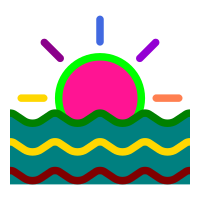

In [8]:
svg.draw_colored()

Convert the SVG to the differentiable SVGTensor data-structure.

In [9]:
svg_target, group_svg_target = svg.to_tensor()
# svg_target = SVGTensor.from_data(svg_target)
# print("svg_target:",svg_target)
# print(svg_target.data)

group_len: 11


In [10]:
new_group = []
for g in group_svg_target:    
    new_group.append(SVGTensor.from_data(g))
print(new_group)

[<deepsvg.difflib.tensor.SVGTensor object at 0x7f39eb948370>, <deepsvg.difflib.tensor.SVGTensor object at 0x7f39eb948340>, <deepsvg.difflib.tensor.SVGTensor object at 0x7f39eb9482b0>, <deepsvg.difflib.tensor.SVGTensor object at 0x7f39eb948550>, <deepsvg.difflib.tensor.SVGTensor object at 0x7f39eb948d00>, <deepsvg.difflib.tensor.SVGTensor object at 0x7f39eb948490>, <deepsvg.difflib.tensor.SVGTensor object at 0x7f39eb948430>, <deepsvg.difflib.tensor.SVGTensor object at 0x7f39eb948220>, <deepsvg.difflib.tensor.SVGTensor object at 0x7f39eb948460>, <deepsvg.difflib.tensor.SVGTensor object at 0x7f39eb9484f0>, <deepsvg.difflib.tensor.SVGTensor object at 0x7f39eb948520>]


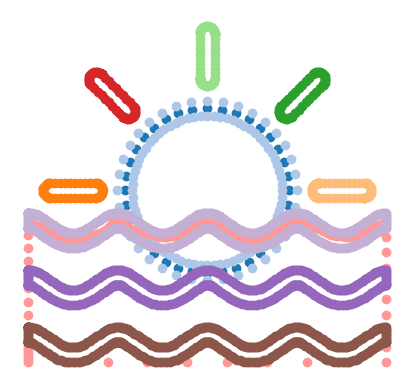

In [11]:
colors = [plt.cm.tab20(x) for x in range(20)]
points = []
for i, g in enumerate(new_group):
    p_target = g.sample_points(n=10)
    points += p_target.tolist()
    plot_points(p_target, colors[i], show_color=False)

In [60]:
# p_target = svg_target.sample_points()
# plot_points(p_target, show_color=False)

Create an arbitrary SVG whose Bézier parameters will be optimized to match the target shape.

In [8]:
circle = SVG.unit_circle().normalize().zoom(0.9).split(8)  # split: 1/2/4/8
svg_pred = SVGTensor.from_data(circle.to_tensor())

SVGTensor enables to sample points in a differentiable way, so that the loss that will be backpropagated down to the SVG Bézier parameters.

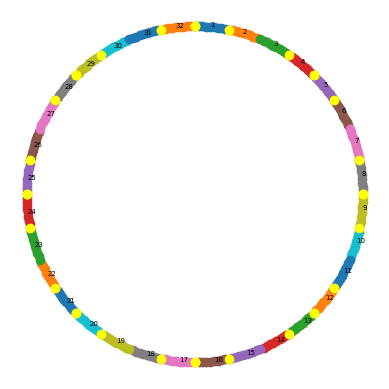

In [10]:
p_pred, nearest_points = svg_pred.sample_points()
plot_points(p_pred,nearest_points, show_color=True)

In [14]:
svg_pred.control1.requires_grad_(True)
svg_pred.control2.requires_grad_(True)
svg_pred.end_pos.requires_grad_(True);

In [15]:
optimizer = optim.Adam([svg_pred.control1, svg_pred.control2, svg_pred.end_pos], lr=0.1)

Write a standard gradient descent algorithm and observe the step-by-step optimization!

In [16]:
img_list = []

for i in range(150):
    optimizer.zero_grad()

    p_pred = svg_pred.sample_points()
    l = svg_emd_loss(p_pred, p_target)
    l.backward()
    optimizer.step()
    
    if i % 4 == 0:
        img = svg_pred.draw(with_points=True, do_display=False, return_png=True)
        img_list.append(img)
            
to_gif(img_list)